In [7]:
# importing the necessary packages
#sources
#http://www.numpy.org/
#https://pandas.pydata.org/
#https://stackoverflow.com/
#http://scikit-learn.org/stable/
import os, json, glob
import os.path as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import json_lines
import scipy.spatial
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [8]:
frames = pd.read_json('walking.jsonl', lines=True)

In [9]:
print(frames.head(1))
print(len(frames))

                                              people  version
0  [{'pose_keypoints_2d': [590.099, 342.58, 0.913...      1.2
519


In [10]:
people_f = frames['people']

In [11]:
print(len(people_f))

519


In [12]:
kp = frames.iloc[:,0]
print(len(kp[0][0]['pose_keypoints_2d']))

54


In [13]:
def get_pose_kp(data):
    x_points = []
    y_points = []
    c_points = []
    for i in range(len(data)):
        res1 = data[i]
        if len(res1) > 0:
            res2 = data[i][0]['pose_keypoints_2d']
            x = x_points.append([res2[k] for k in range(0,54,3)])
            y = y_points.append([res2[k] for k in range(1,54,3)])
            c = c_points.append([res2[k] for k in range(2,54,3)])
            
    hip_right_x = [x[8] for x in x_points]
    knee_right_x = [x[9] for x in x_points]
    foot_right_x = [x[10] for x in x_points]
    
    hip_right_y = [y[8] for y in y_points]
    knee_right_y = [y[9] for y in y_points]
    foot_right_y = [y[10] for y in y_points]
    
    hip_right_c = [c[8] for c in c_points]
    knee_right_c = [c[9] for c in c_points]
    foot_right_c = [c[10] for c in c_points]
    
    hip_left_x = [x[11] for x in x_points]
    knee_left_x = [x[12] for x in x_points]
    foot_left_x = [x[13] for x in x_points]
    
    hip_left_y = [y[11] for y in y_points]
    knee_left_y = [y[12] for y in y_points]
    foot_left_y = [y[13] for y in y_points]
    
    hip_left_c = [c[11] for c in c_points]
    knee_left_c = [c[12] for c in c_points]
    foot_left_c = [c[13] for c in c_points]
    
    centre_x = [x[1] for x in x_points]
    centre_y = [y[1] for y in y_points]
    centre_c = [c[1] for c in c_points]
    
    centre = list(zip(centre_x, centre_y, centre_c))
    
    hip_right = list(zip(hip_right_x, hip_right_y, hip_right_c))
    knee_right = list(zip(knee_right_x,knee_right_y,knee_right_c))
    foot_right = list(zip(foot_right_x, foot_right_y, foot_right_c))
    
    hip_left = list(zip(hip_left_x, hip_left_y, hip_left_c))
    knee_left = list(zip(knee_left_x,knee_left_y,knee_left_c))
    foot_left = list(zip(foot_left_x, foot_left_y, foot_left_c))
    
    right_hip = pd.DataFrame(hip_right, columns=['x', 'y', 'c'])
    print(right_hip.head())
    right_knee = pd.DataFrame(knee_right, columns=['x', 'y', 'c'])
    right_foot = pd.DataFrame(foot_right, columns=['x', 'y', 'c'])
    left_hip = pd.DataFrame(hip_left, columns=['x', 'y', 'c'])
    left_knee = pd.DataFrame(knee_left, columns=['x', 'y', 'c'])
    left_foot = pd.DataFrame(foot_left, columns=['x', 'y', 'c'])
    centre = pd.DataFrame(centre, columns =['x', 'y', 'c'])
    print(centre.head(5))

    right_norm = np.linalg.norm(centre.iloc[:,:2] - right_hip.iloc[:,:2], axis = 1).reshape((519, 1))
    print(right_norm[:5])

    
    left_norm = np.linalg.norm(centre.iloc[:,:2] - left_hip.iloc[:,:2], axis = 1).reshape((519, 1))
    print(left_norm[:5])
    #norm = pd.concat([right_norm,left_norm])
    norm = np.stack((right_norm, left_norm), axis = 1).reshape((519,2))
    #print(norm.shape)
    mean_norm = np.mean(norm, axis = 1).reshape((519,1))
    print(mean_norm[:5])
    #by_row_index1 = norm.groupby(norm.index)
    #mean_norm = by_row_index1.mean()
    #mean_norm = pd.DataFrame(mean_norm)

    #right_foot_norm = np.divide(right_foot, mean_norm)
    right_foot_norm = abs((right_foot - right_foot.mean(axis = 0 ))/right_foot.std(axis = 0))
    right_foot_norm = pd.DataFrame(right_foot_norm)
    print(right_foot_norm.head())
    
    #left foot norm
    left_foot_norm = abs((left_foot - left_foot.mean(axis = 0 ))/left_foot.std(axis = 0))
    left_foot_norm = pd.DataFrame(left_foot_norm)
    print(left_foot_norm.head())
    
    diff_left = np.sqrt(np.power(left_foot_norm['x'].shift()-left_foot_norm['x'],2)+np.power(left_foot_norm['y'].shift()-left_foot_norm['y'],2))
    left_diff = pd.DataFrame(diff_left)
    left_diff = left_diff.fillna(0)
    print(left_diff.head())

    diff_right = np.sqrt(np.power(right_foot_norm['x'].shift()-right_foot_norm['x'],2)+np.power(right_foot_norm['y'].shift()-right_foot_norm['y'],2))
    right_diff = pd.DataFrame(diff_right)
    right_diff = right_diff.fillna(0)
    right_diff = right_diff[right_diff[0]<2]
    print(right_diff.head())
    print(len(right_diff))

    #plt.plot(right_diff.index, right_diff, linewidth = 0.5)
    #plt.savefig('right_gait_velocity')
    #right_ts = plt.plot(right_diff, linewidth = 0.5)
    autocorrelation_plot(right_diff)
    right_acf = acf(right_diff, unbiased=False, nlags=517, qstat=False, fft=False, alpha=None, missing='None')
    print(len(right_acf))
    #plot_acf(right_diff, ax=None, lags=516, alpha=None, use_vlines=True, unbiased=False, fft=False, 
             #title='Autocorrelation', zero=True, vlines_kwargs= marker)
    #plt.show()
    #plt.savefig('right_gait_acf')

    
    #ary = scipy.spatial.distance.euclidean(right_hip.iloc[:,:1], right_foot.iloc[:,:1])
    dist_right =  np.linalg.norm(right_hip.iloc[:,:2] - right_foot.iloc[:,:2], axis = 1).reshape((519, 1))
    #dist_right = np.sqrt(np.power(right_hip['x']-right_foot['x'],2)+np.power(right_hip['y']-right_foot['y'],2)).reshape((519,1))
    print(dist_right.shape)
    right_leg_length = np.divide(dist_right, mean_norm) * 100
    #right_leg_length = dist_right.divide(mean_norm) * 100
    right_leg_length = pd.DataFrame(right_leg_length)
    right_leg_length.index += 1
    right_leg_length.index.name = 'timeFrame'
    right_leg_length.columns = ['distance']
    print(right_leg_length.head())
    
    
    dist_left =  np.linalg.norm(left_hip.iloc[:,:2] - left_foot.iloc[:,:2], axis = 1).reshape((519, 1))
    #dist_left = np.sqrt(np.power(left_hip['x']-left_foot['x'],2)+np.power(left_hip['y']-left_foot['y'],2))
    
    #diff = np.sqrt(np.power(df1['x'].shift()-df1['x'],2)+np.power(df1['y'].shift()-df1['y'],2))

    print(dist_left.shape)
    left_leg_length = np.divide(dist_left, mean_norm) * 100
    #left_leg_length = dist_left.divide(mean_norm) * 100                  
    left_leg_length = pd.DataFrame(left_leg_length)
    left_leg_length.index += 1
    left_leg_length.index.name = 'timeFrame'
    left_leg_length.columns = ['distance']
    #print(left_leg_length.head())
    
    right_leg_length.to_csv('right_leg.csv')
    #left_leg_length.to_csv('left_leg.csv')
    
    return len(right_leg_length), len(left_leg_length)

         x        y         c
0  569.509  460.312  0.894316
1  572.326  460.326  0.900217
2  572.350  460.447  0.894632
3  572.320  460.470  0.883616
4  572.369  460.530  0.880636
         x        y         c
0  590.091  383.734  0.847172
1  590.135  383.773  0.845190
2  592.991  386.557  0.859476
3  590.113  386.651  0.872686
4  592.989  386.704  0.877572
[[79.29570485]
 [78.59721554]
 [76.71885675]
 [75.93309957]
 [76.65156669]]
[[78.45586015]
 [79.43040522]
 [78.46489203]
 [79.39132258]
 [78.37671502]]
[[78.8757825 ]
 [79.01381038]
 [77.59187439]
 [77.66221107]
 [77.51414085]]
          x         y         c
0  0.009810  0.256556  0.695370
1  0.009852  0.244348  0.632780
2  0.009615  0.256299  0.670271
3  0.009751  0.244261  0.654603
4  0.009668  0.244104  0.639492
          x         y         c
0  0.261490  0.391668  0.508555
1  0.261204  0.391723  0.494271
2  0.241310  0.391668  0.514292
3  0.261253  0.379046  0.500573
4  0.261657  0.378758  0.496516
          0
0  0.000000
1  0

/Users/tanmaiyiirao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


(519, 519)

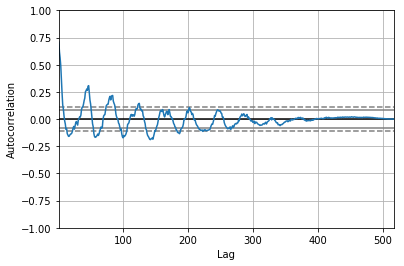

In [21]:
get_pose_kp(kp)

In [ ]:
def get_normalised_vector():
    
    

In [18]:
hip = np.array([569.509000, 460.312000])
foot = np.array([578.367000,578.416000])

dist = np.linalg.norm(hip - foot)
dist2 = np.sqrt(np.sum((hip-foot)**2))


In [19]:
print(dist, dist2)

118.43571665675861 118.43571665675861
